In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
from logzero import logger

from config import designated_date, window
from constants import JSON_PATH, SHEET_NAME, SS_ID
from utils import (
    ColorCodes,
    LogSettingRunner,
    correct_bad_records,
    create_df_long,
    get_worksheet_values,
    output_graph,
)
from validates import (
    validate_bad_records,
    validate_calendar_null_date,
    validate_data_types,
    validates_24hours,
    validates_calculate_moving_average,
)

[I 240108 17:17:39 1802421585:10] Bad records num:3
[I 240108 17:17:39 1802421585:16] Bad records index:[92, 95, 620]


Bad records num: 0
Data types validation passed!


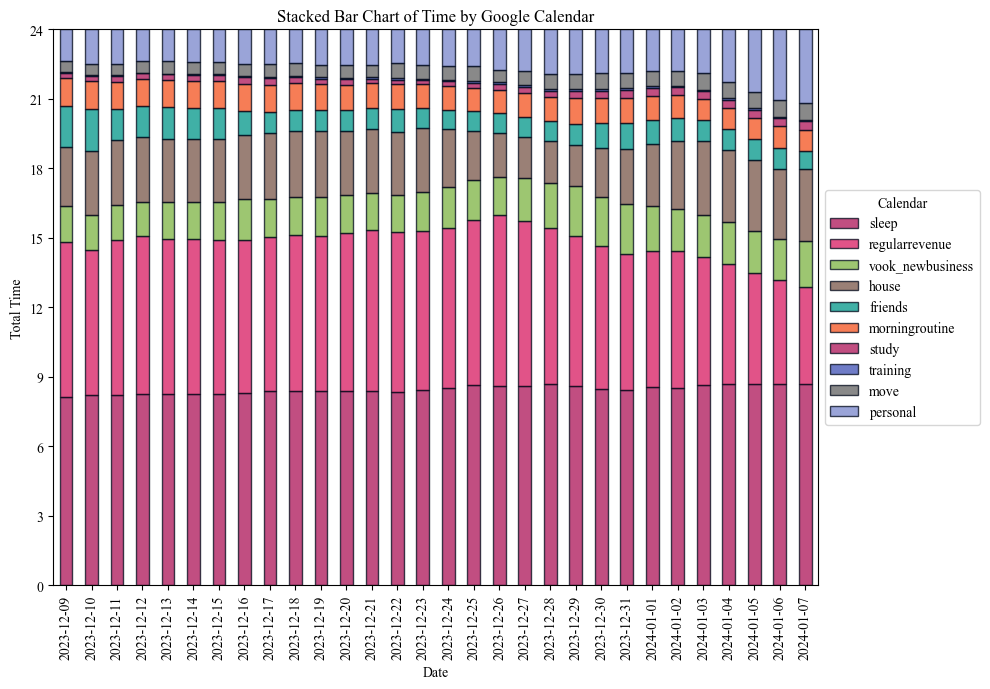

In [2]:
# ログの設定
LogSettingRunner.run()

# ローデータを取得する
sheet = get_worksheet_values(JSON_PATH, SS_ID, SHEET_NAME)
validate_calendar_null_date(sheet)

# 縦持ちのデータを作る
df_long = create_df_long(sheet)
logger.info(
    f"Bad records num:{df_long[df_long['time'] == '#NUM!'].shape[0]}",
)

# 不正なレコードを修正する
bad_rec_index = df_long[df_long["time"] == "#NUM!"].index.tolist()
logger.info(f"Bad records index:{bad_rec_index}")
df_long = correct_bad_records(df_long, bad_rec_index)
validate_bad_records(df_long)

# データ型の定義:型の前提をここでFIXする
df_long["date"] = pd.to_datetime(df_long["date"])
df_long["time"] = df_long["time"].astype(float)
validate_data_types(df_long)

# 移動平均の計算準備のため
df_long.set_index("date", inplace=True)
df_long.sort_index(inplace=True)

# 移動平均の計算
df_calc_ma = (
    df_long.groupby("calendar")["time"]
    .rolling(window=window, min_periods=1)
    .mean()
    .reset_index()
)
validates_calculate_moving_average(df_long, df_calc_ma, "2024-01-01", window)

# 指定日からwindow分の移動平均を描画するため
designated_date = datetime.strptime(designated_date, "%Y-%m-%d")
min_date = designated_date - relativedelta(days=window - 1)
df_calc_maspecified_period = df_calc_ma[
    (df_calc_ma["date"] >= min_date) & (df_calc_ma["date"] <= designated_date)
].sort_values(by="date")

# データフレームをピボットして日付ごとにカレンダーカテゴリの時間を積み上げる
df_pivot = df_calc_maspecified_period.pivot_table(
    index="date", columns="calendar", values="time", aggfunc="sum"
)
# 重要な順番で下から積み上がるようにするため
df_pivot = df_pivot[
    [
        "sleep",
        "regularrevenue",
        "vook_newbusiness",
        "house",
        "friends",
        "morningroutine",
        "study",
        "training",
        "move",
        "personal",
    ]
]
output_graph(df_pivot, window, True)